# Image search in e-commerce

This use-case notebook shows semantic search in fashion images. 

In e-commerce, being able to serve user queries with the most relevant results is of utmost importance. Users predominantly use text to describe what they would like and that poses a problem e-commerce websites face: products generally lack extensive textual information. However, there is no better way to describe a product than an image. Luckily, researchers also realised that, and came up with multi-modal Vision Transformers that embed text and images in the same space, thereby making us able to search with text in images of products. Namely, searching for an "elegant dress" does not require the description to contain anything similar to return the actual elegant dresses.

To demonstrate that, we are going to perform search in a fashion dataset consinsting of images with short descriptions. We will be able to search:
- with text in the descriptions,
- with text in the images,
- with an image in the images

or we can combine these in the following ways:
- search with the same or different text in the descriptions and the images
- search with text in the descriptions, and with images in the images

we will show that multi-modal search in the text embedding AND the image embedding space is the best approach to get the most relevant results.

In [1]:
%pip install superlinked==9.32.2
%pip install datasets
%pip install matplotlib
%pip install open-clip-torch

In [2]:
import logging
import matplotlib.pyplot as plt
import open_clip
import pandas as pd
import PIL.Image
import requests
import torch

from datasets import load_dataset
from io import BytesIO
from tqdm import tqdm

from superlinked.framework.common.schema.id_schema_object import IdField
from superlinked.framework.common.schema.schema import schema
from superlinked.framework.common.schema.schema_object import FloatList, String
from superlinked.framework.dsl.executor.in_memory.in_memory_executor import (
    InMemoryExecutor,
)
from superlinked.framework.dsl.index.index import Index
from superlinked.framework.dsl.source.in_memory_source import InMemorySource
from superlinked.framework.dsl.space.custom_space import (
    CustomSpace,
)
from superlinked.framework.dsl.space.text_similarity_space import TextSimilaritySpace
from superlinked.framework.dsl.query.param import Param
from superlinked.framework.dsl.query.query import Query

logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

DATASET_ID: str = "ceyda/fashion-products-small"
VIT_MODEL_ID: str = "hf-hub:Marqo/marqo-fashionCLIP"
WATCH_IMAGE_URL: str = (
    "https://storage.googleapis.com/superlinked-notebook-image-search/watch.jpg"
)
REDO_FILTERING: bool = True
NUM_SAMPLES = 2000
SEED = 42
LIMIT = 4

## Create Image embeddings

Let's use Margo's state-of-the-art model to embed a fashion product dataset!

### Load model

In [3]:
%%capture
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms(
    VIT_MODEL_ID
)
tokenizer = open_clip.get_tokenizer(VIT_MODEL_ID)

### Load data

In [4]:
# depending on your internet connection, downloading the dataset for the first time may take several minutes.
fashion_dataset = load_dataset(DATASET_ID)
fashion_sample_dataset = (
    fashion_dataset["train"].shuffle(seed=SEED).select(range(NUM_SAMPLES))
)

Repo card metadata block was not found. Setting CardData to empty.


### Organize metadata

In [5]:
fashion_sample_dataset[0]

{'filename': '29985.jpg',
 'link': 'http://assets.myntassets.com/v1/images/style/properties/Aspen-Women-Black-Dial-Watch_256e45a6bab70dcaea70118b3f0c70d3_images.jpg',
 'id': '29985',
 'masterCategory': 'Free Items',
 'gender': 'Women',
 'subCategory': 'Free Gifts',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x512>}

In [6]:
json_data = [
    {
        "category": item["masterCategory"],
        "subcategory": item["subCategory"],
        "gender": item["gender"],
        "id": i,
    }
    for i, item in enumerate(fashion_sample_dataset)
]
fashion_df = pd.DataFrame(json_data)
fashion_df["description"] = fashion_df[["gender", "category", "subcategory"]].agg(
    " ".join, axis=1
)
fashion_df.head()

,category,subcategory,gender,id,description
0,Free Items,Free Gifts,Women,0,Women Free Items Free Gifts
1,Accessories,Bags,Women,1,Women Accessories Bags
2,Apparel,Topwear,Women,2,Women Apparel Topwear
3,Personal Care,Fragrance,Unisex,3,Unisex Personal Care Fragrance
4,Apparel,Innerwear,Men,4,Men Apparel Innerwear


### Quickly try the model out

Let's explore multi-modality in the shared embedding space by finding the textual label whose embedding is closest to that of a watch image.

Here is a sample picture of a casual watch:

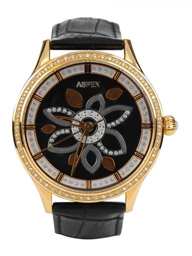

In [7]:
sample_picture = fashion_sample_dataset[0]["image"]
sample_picture.resize([int(size_dim / 2) for size_dim in sample_picture.size])

Now, let's demonstrate that text and image representations are closely aligned in the same embedding space when they refer to the same concept.

In [8]:
image = preprocess_val(fashion_dataset["train"][0]["image"]).unsqueeze(0)
raw_text = ["a hat", "a t-shirt", "watch", "shoes"]
text = tokenizer(raw_text)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    text_probs = (image_features @ text_features.T).softmax(dim=-1)

label_prob_data = pd.DataFrame.from_dict(
    {
        label: round(text_prob, 4)
        for label, text_prob in zip(raw_text, text_probs[0].tolist())
    },
    orient="index",
    columns=["similarity"],
)

print("Label probs:")
label_prob_data

Label probs:


,similarity
a hat,0.0000
a t-shirt,0.0110
watch,0.9889
shoes,0.0001


The most probable label is watch by a unambiguous margin.

### Embed our dataset

In [9]:
# helper to embed text with the Vision Transformer
def encode_text(model, text: str, tokenizer) -> list[float]:
    text_tokenized = tokenizer(text)
    text_features = model.encode_text(text_tokenized)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features[0].tolist()


# helper to embed images with the Vision Transformer
def encode_image(model, image) -> list[float]:
    image = preprocess_val(image).unsqueeze(0)
    image_features = model.encode_image(image)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features[0].tolist()

In [10]:
image_embeddings = []
with torch.no_grad():
    for fashion_item in tqdm(fashion_sample_dataset):
        image_features = encode_image(model, fashion_item["image"])
        image_embeddings.append(image_features)

100%|██████████| 2000/2000 [01:54<00:00, 17.46it/s]


In [11]:
# store data in json to easily ingest to superlinked later
fashion_df["image_embedding"] = image_embeddings
json_data: list[dict[Hashable, Any]] = fashion_df.to_dict(orient="records")

## Superlinked setup

Now let's set Superlinked up to perform multi-modal vector search on our dataset!

In [12]:
@schema
class Image:
    id: IdField
    image_embedding: FloatList  # we need to supply image embedding vectors using this SchemaFieldType
    description: String


image = Image()

In [13]:
# CustomSpace enables ingesting any particular vector embedding
image_embedding_space = CustomSpace(
    vector=image.image_embedding,
    length=512,
    aggregation=CustomSpace.AggregationStrategy.SUM_AND_NORMALIZE,
)
# Embed descriptions using a text embedding model
description_space = TextSimilaritySpace(
    text=image.description, model="Alibaba-NLP/gte-large-en-v1.5"
)

# construct an index
composite_index = Index([image_embedding_space, description_space])

In [14]:
source: InMemorySource = InMemorySource(image)
executor = InMemoryExecutor(sources=[source], indices=[composite_index])
app = executor.run()

In [15]:
source.put(json_data)

In [16]:
DUMMY_IMAGE = [0] * 512
DUMMY_TEXT = ""

combined_query = (
    Query(
        composite_index,
        weights={
            description_space: Param("description_weight"),
            image_embedding_space: Param("image_embedding_weight"),
        },
    )
    .find(image)
    .similar(description_space.text, Param("text_search"))
    .similar(image_embedding_space.vector, Param("image_search"))
    .limit(LIMIT)
)

## Search images

In [17]:
# helper functions to plot image results
def plot_result_pictures(result_df: pd.DataFrame) -> None:
    fig, ax = plt.subplots(1, LIMIT, figsize=(LIMIT * 3, 2))
    ax = ax.flatten()
    result_num = 1
    for result_id, ax_ in zip(result_df["id"].tolist(), ax):
        ax_.imshow(fashion_sample_dataset["image"][int(result_id)])
        ax_.set_title(f"Result {result_num}", fontsize=16)
        result_num += 1
        ax_.set_axis_off()


def plot_result_picture_comparison(result_df_map: dict[str, pd.DataFrame]) -> None:
    num_results = len(result_df_map.keys())
    fig = plt.figure(constrained_layout=True, figsize=(3 * num_results, 5 * LIMIT / 2))
    fig.suptitle("Result comparison", fontsize=16)

    # create 3x1 subfigs
    subfigs = fig.subfigures(nrows=num_results, ncols=1)
    for subfig, (label, result_df) in zip(subfigs, result_df_map.items()):
        subfig.suptitle(f"{label}", fontsize=12)

        # create 1x3 subplots per subfig
        axs = subfig.subplots(nrows=1, ncols=LIMIT)
        for col, ax in enumerate(axs):
            ax.imshow(fashion_sample_dataset["image"][int(result_df["id"].iloc[col])])
            ax.set_title(f"Result {col+1}", fontsize=10)
            ax.set_axis_off()

### Search with text in the description field

Let's first try searching only with text in the descriptions of the products. This approach requires extensive descriptions to work well.

In [18]:
result_text = app.query(
    combined_query,
    description_weight=1,
    image_embedding_weight=0,
    text_search="elegant womens watches",
    image_search=DUMMY_IMAGE,
)

result_text_df = result_text.to_pandas()
result_text_df

,image_embedding,description,id,similarity_score
0,"[0.02161378040909767, 0.029347164556384087, 0....",Women Accessories Watches,148,0.571299
1,"[0.013196209445595741, 0.006079528946429491, 0...",Women Accessories Watches,324,0.571299
2,"[-0.002630330389365554, 0.06414414942264557, -...",Women Accessories Watches,385,0.571299
3,"[0.03506641462445259, 0.005878141615539789, -0...",Women Accessories Watches,1321,0.571299


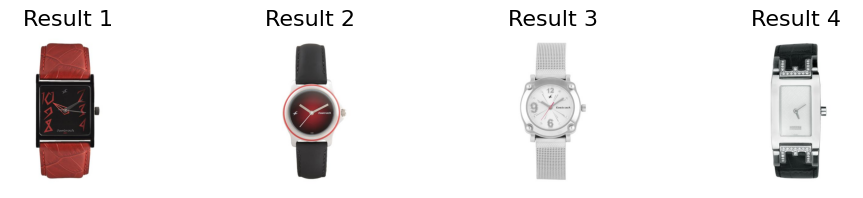

In [19]:
plot_result_pictures(result_text_df)

It can be spotted that the "elegant" part is not present in the descriptions, so it is only accidentally present in the results.

### Search with text in the image space

In [20]:
result_text_in_images = app.query(
    combined_query,
    description_weight=0,
    image_embedding_weight=1,
    text_search=DUMMY_TEXT,
    image_search=encode_text(model, "elegant womens watches", tokenizer),
)

result_text_in_images_df = result_text_in_images.to_pandas()
result_text_in_images_df

,image_embedding,description,id,similarity_score
0,"[0.00528308330103755, 0.03582894429564476, 0.0...",Women Accessories Watches,755,0.166988
1,"[-0.013235913589596748, 0.03211177885532379, 0...",Women Free Items Free Gifts,0,0.163754
2,"[-0.04502682387828827, 0.0471847727894783, 0.0...",Women Accessories Watches,814,0.163012
3,"[-0.02132037654519081, -0.003266318002715707, ...",Women Accessories Watches,1991,0.161860


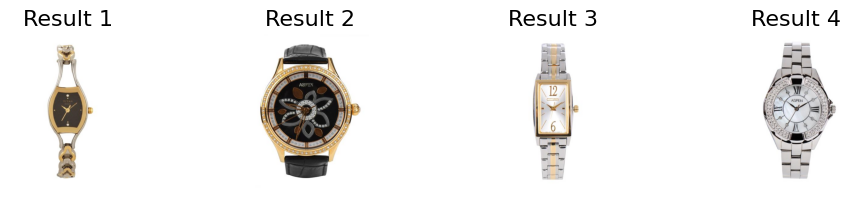

In [21]:
plot_result_pictures(result_text_in_images_df)

Searching with text in the image space definitely improves the results, but there is a false negative present in the 2nd position.

### Search with image in image space

It is also possible to search with a reference image in the image embedding space.

In [22]:
# helper function to read an image from a public gcs bucket
def open_image_from_public_gcs(public_url):
    # Construct the public URL for the GCS object
    public_url = WATCH_IMAGE_URL

    # Fetch the image using the public URL
    response = requests.get(public_url)

    # Ensure the request was successful
    if response.status_code == 200:
        # Open the image with PIL using the downloaded bytes
        image = PIL.Image.open(BytesIO(response.content))
        return image
    else:
        raise Exception(f"Failed to fetch image. Status code: {response.status_code}")

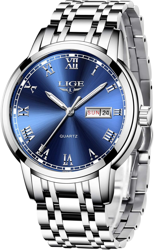

In [23]:
watch_image = open_image_from_public_gcs(WATCH_IMAGE_URL)
watch_image.resize([int(size_dim / 6) for size_dim in watch_image.size])

In [24]:
watch_embedding = encode_image(model, watch_image)

result_image = app.query(
    combined_query,
    description_weight=0,
    image_embedding_weight=1,
    text_search=DUMMY_TEXT,
    image_search=watch_embedding,
    limit=4,
)

result_image_df = result_image.to_pandas()
result_image_df

,image_embedding,description,id,similarity_score
0,"[-0.04296264052391052, 0.051185302436351776, 0...",Men Accessories Watches,342,0.440776
1,"[0.001402578316628933, 0.01875554583966732, -0...",Men Accessories Watches,724,0.415156
2,"[-0.05601915344595909, -0.009956897236406803, ...",Men Accessories Watches,1818,0.404763
3,"[-0.018913349136710167, 0.021825285628437996, ...",Men Accessories Watches,1042,0.399535


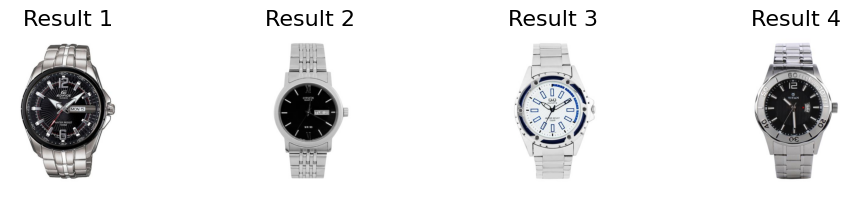

In [25]:
plot_result_pictures(result_image_df)

The results are indeed quite similar to the reference image.

### Search with text in the description space and image in the image space

In [26]:
result_text_image_combined = app.query(
    combined_query,
    description_weight=1,
    image_embedding_weight=1,
    text_search="elegant womens watches",
    image_search=watch_embedding,
    limit=4,
)

result_text_image_combined_df = result_text_image_combined.to_pandas()
result_text_image_combined_df

,image_embedding,description,id,similarity_score
0,"[-0.002617527963593602, -0.027942059561610222,...",Women Accessories Watches,143,0.648307
1,"[-0.02132037654519081, -0.003266318002715707, ...",Women Accessories Watches,1991,0.647730
2,"[-0.031321652233600616, 0.021846389397978783, ...",Women Accessories Watches,480,0.642841
3,"[-0.04502682387828827, 0.0471847727894783, 0.0...",Women Accessories Watches,814,0.634575


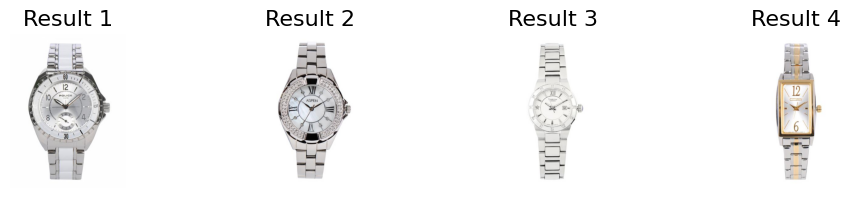

In [27]:
plot_result_pictures(result_text_image_combined_df)

Using a reference image and text to search in descriptions seems to be the best way to ensure result quality.

### Search with text in the description space and image in the image space

In [28]:
search_text = "elegant womens watches"

result_text_image = app.query(
    combined_query,
    description_weight=1,
    image_embedding_weight=1,
    text_search=search_text,
    image_search=encode_text(model, search_text, tokenizer),
    limit=4,
)

result_text_image_df = result_text_image.to_pandas()
result_text_image_df

,image_embedding,description,id,similarity_score
0,"[0.00528308330103755, 0.03582894429564476, 0.0...",Women Accessories Watches,755,0.522048
1,"[-0.04502682387828827, 0.0471847727894783, 0.0...",Women Accessories Watches,814,0.519236
2,"[-0.02132037654519081, -0.003266318002715707, ...",Women Accessories Watches,1991,0.518422
3,"[-0.002630330389365554, 0.06414414942264557, -...",Women Accessories Watches,385,0.515302


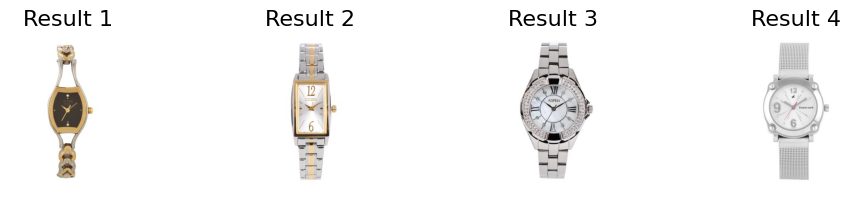

In [29]:
plot_result_pictures(result_text_image_df)

A similarly powerful approach is to search with the same text in the description and in the image embedding space.

## Result comparison

Lets compare the most promising results to the simple text search for elegant womens watches. Also take it into account that users rarely search with a reference image, they rather use text.

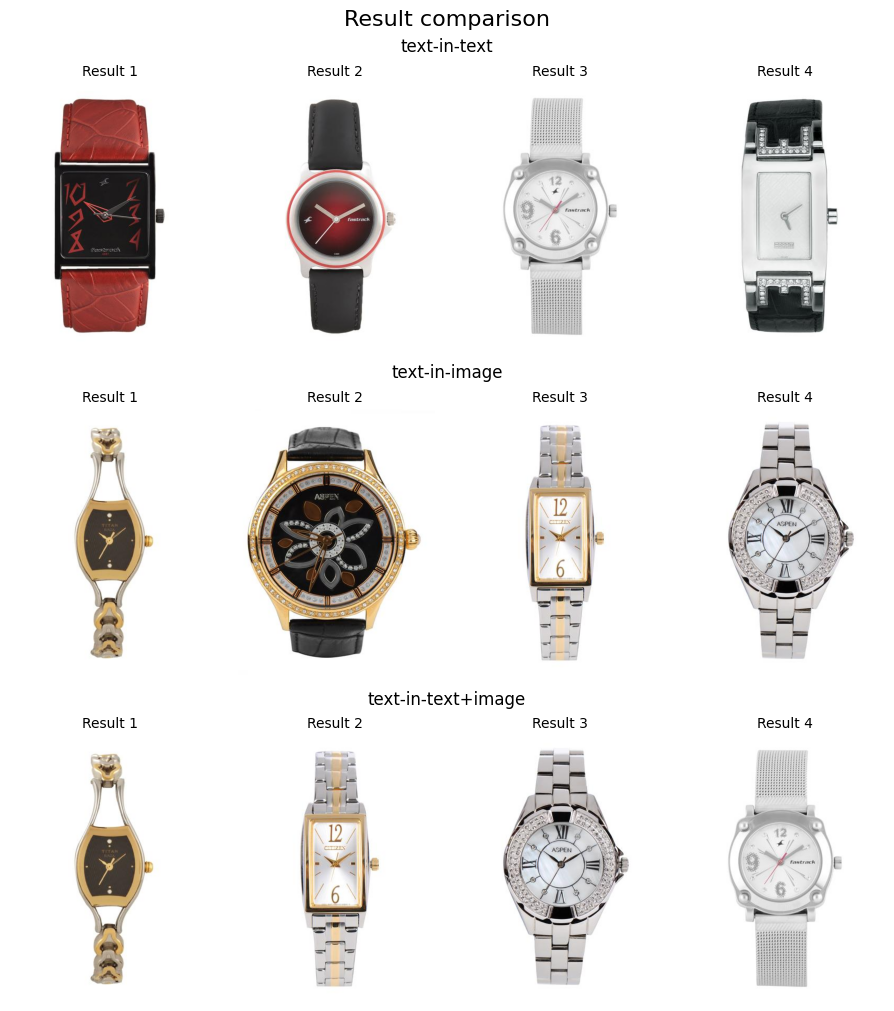

In [30]:
result_df_map = {
    "text-in-text": result_text_df,
    "text-in-image": result_text_in_images_df,
    "text-in-text+image": result_text_image_df,
}

plot_result_picture_comparison(result_df_map)

## Summary

1. `text-in-text` search is suboptimal due to the lack of detail in product descriptions.
1. `text-in-image` search creates a substantial improvement but arguably shows a false positive at `Result 2`.
1. `text-in-text+image` search improves upon the `text-in-image` by removing the false positive through cross-checking it's description. The new watch at `Result 4` is definitely more elegant than the previously mentioned watch at position `Result 2` in the `text-in-image` results.

As a conclusion, utilizing multi-modal vector search improves upon using even the most sophisticated in itself multi-modal image+text embedding models.